In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from joblib import load

from config import EXPERIMENT, RUN_NAME, ARTIFACT_DIR
from logger import logger
from mlflow_utils import evaluate_binary, log_mlflow

In [46]:
# Tag this cell as 'parameters'
INDEX = 'SNP'

In [47]:
# Wrap all this is a parameter dict
run_params = {'experiment': EXPERIMENT,
              'iteration': RUN_NAME,
              'index': INDEX,
              'artifact_dir': ARTIFACT_DIR}

### Import data

In [48]:
df = pd.read_csv('../datadir/{}.csv'.format(INDEX))

### Data prep

In [49]:
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

In [50]:
df.sort_values(by='date', ascending=True, inplace=True)  # Have to sort ascending for rolling to work correctly

### Create basic features

In [51]:
df = df[['date', 'open', 'adj_close']].copy()

In [52]:
df['prev'] = df['adj_close'].shift(1)

In [53]:
df['sma2'] = df['prev'].rolling(window=2).mean()
df['sma5'] = df['prev'].rolling(window=5).mean()
df['sma10'] = df['prev'].rolling(window=10).mean()
df['sma20'] = df['prev'].rolling(window=20).mean()

In [54]:
assert round(df['prev'].tail(5).mean(), 4) == round(df['sma5'].tail(1).item(), 4), 'Expected sma5 to be same as mean of past 5 items'
assert round(df['prev'].tail(10).mean(), 4) == round(df['sma10'].tail(1).item(), 4), 'Expected sma10 to be same as mean of past 10 items'
assert round(df['prev'].tail(20).mean(), 4) == round(df['sma20'].tail(1).item(), 4), 'Expected sma20 to be same as mean of past 20 items'

In [55]:
df['ema12'] = df['prev'].ewm(span=12, min_periods=12, adjust=False).mean()
df['ema26'] = df['prev'].ewm(span=26, min_periods=26, adjust=False).mean()

In [56]:
def difference(prev_price, moving_average):
    return (prev_price - moving_average) / prev_price

In [57]:
for col in ['sma2', 'sma5', 'sma10', 'sma20', 'ema12', 'ema26']:
    df['{}_diff'.format(col)] = difference(df['prev'], df[col])

In [58]:
df.dropna(inplace=True)

In [59]:
df.shape

(227, 16)

In [60]:
df.drop(columns=['date', 'open'], inplace=True)

### Create label

In [61]:
df['label'] = (df['adj_close'] > df['prev']).astype(int)

### Train-val split

In [62]:
# Keep most recent 20 days as validation set

In [63]:
validation_days = 20
train = df.iloc[:-validation_days].copy()
val = df.iloc[-validation_days:].copy()
logger.info('No. of days - Train: {}, Val: {}'.format(train.shape[0], val.shape[0]))

[05/Dec/2021 00:40:28] INFO - No. of days - Train: 207, Val: 20


### Basic visualizations

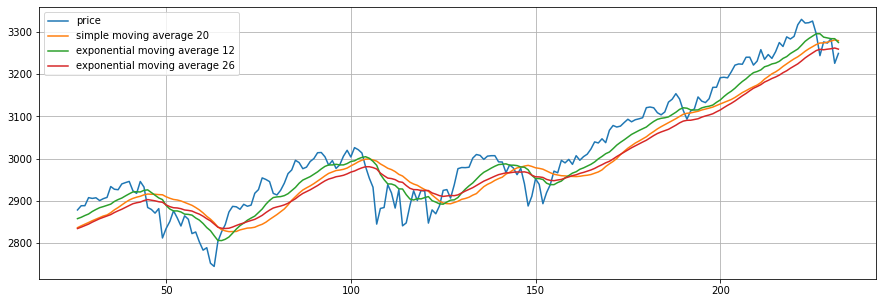

In [64]:
plt.figure(figsize=(15, 5))
plt.grid()
plt.plot(train['adj_close'], label='price')
plt.plot(train['sma20'], label='simple moving average 20')
plt.plot(train['ema12'], label='exponential moving average 12')
plt.plot(train['ema26'], label='exponential moving average 26')
plt.legend()

### Feature transformations

In [65]:
scaler = StandardScaler()

In [66]:
COLS_TO_SCALE = ['prev', 'sma2', 'sma5', 'sma10', 'sma20', 'ema12', 'ema26']

In [67]:
scaler.fit(train[COLS_TO_SCALE])

StandardScaler()

In [68]:
train[COLS_TO_SCALE] = scaler.transform(train[COLS_TO_SCALE])
val[COLS_TO_SCALE] = scaler.transform(val[COLS_TO_SCALE])

### Linear regression coefficients

In [69]:
x_variables = '+'.join(list(train.columns[1:-1]))
logger.info('x variables: {}'.format(x_variables))

[05/Dec/2021 00:40:28] INFO - x variables: prev+sma2+sma5+sma10+sma20+ema12+ema26+sma2_diff+sma5_diff+sma10_diff+sma20_diff+ema12_diff+ema26_diff


In [70]:
results = smf.ols('adj_close ~ {}'.format(x_variables), data=train).fit()

In [71]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              adj_close   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     578.1
Date:                Sun, 05 Dec 2021   Prob (F-statistic):          8.72e-147
Time:                        00:40:29   Log-Likelihood:                -930.76
No. Observations:                 207   AIC:                             1890.
Df Residuals:                     193   BIC:                             1936.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3041.1045     46.445     65.478      0.0

### Drop label col

In [72]:
train.drop(columns=['adj_close'], inplace=True)
val.drop(columns=['adj_close'], inplace=True)

### Logistic Regression Coefficients

In [73]:
y = train['label'].values
X = train.drop(columns=['label'])

In [74]:
X = add_constant(X)

In [75]:
logit = sm.Logit(y, X)

In [76]:
result = logit.fit()
print(result.summary())

         Current function value: 1.780240
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  207
Model:                          Logit   Df Residuals:                      193
Method:                           MLE   Df Model:                           13
Date:                Sun, 05 Dec 2021   Pseudo R-squ.:                  -1.617
Time:                        00:40:29   Log-Likelihood:                -368.51
converged:                      False   LL-Null:                       -140.84
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         64.3716     15.369      4.188      0.000      34.249      94.494
prev        -596.4932    150.250     -3.970      0.000    -890.97

D:\Softwares\miniconda3\envs\mlops\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Train some basic models

In [77]:
y_train = train['label'].values
X_train = train.drop(columns='label').values

y_val = val['label'].values
X_val = val.drop(columns='label').values

[05/Dec/2021 00:40:29] INFO - AUC: 0.303 | Recall: 0.889 | Precision: 0.444 | F1: 0.593
[05/Dec/2021 00:40:30] INFO - ROC curve saved to: ../artifact_dir/plots/roc_curve_Logistic Regression (auc = 0.30).png
[05/Dec/2021 00:40:30] INFO - Precision-recall curve saved to: ../artifact_dir/plots/precision_recall_Logistic Regression (prec = 0.44, recall = 0.89).png
[05/Dec/2021 00:40:30] INFO - Model saved to: ../artifact_dir/models/Logistic Regression.pickle


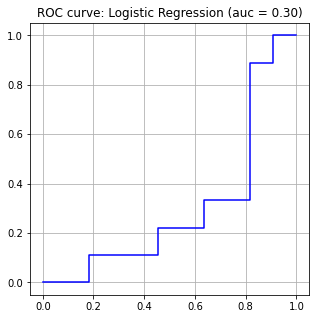

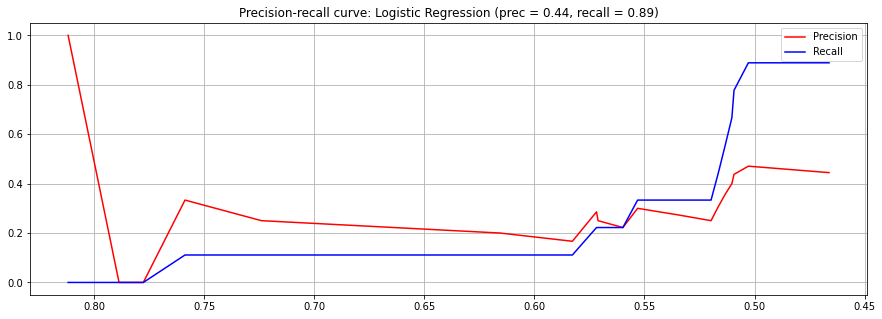

In [78]:
# Logistic regression
model_name = 'Logistic Regression'
model = LogisticRegression(fit_intercept=False).fit(X_train, y_train)
pred = model.predict_proba(X_val)[:, 1]
log_mlflow(run_params, model, model_name, y_val, pred)

[05/Dec/2021 00:40:30] INFO - AUC: 0.707 | Recall: 1.000 | Precision: 0.450 | F1: 0.621
[05/Dec/2021 00:40:30] INFO - ROC curve saved to: ../artifact_dir/plots/roc_curve_Support Vector Classifier (auc = 0.71).png
[05/Dec/2021 00:40:30] INFO - Precision-recall curve saved to: ../artifact_dir/plots/precision_recall_Support Vector Classifier (prec = 0.45, recall = 1.00).png
[05/Dec/2021 00:40:30] INFO - Model saved to: ../artifact_dir/models/Support Vector Classifier.pickle


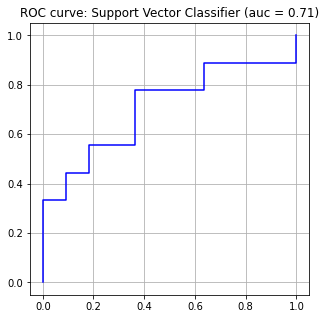

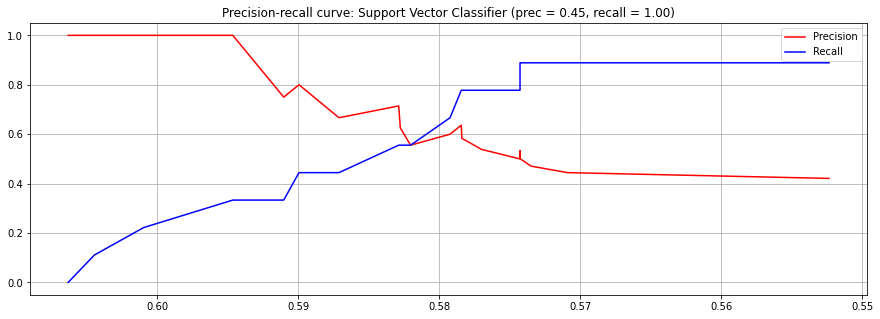

In [79]:
# Support vector classifier
model_name = 'Support Vector Classifier'
model = SVC(gamma=2, C=1, probability=True).fit(X_train, y_train)
pred = model.predict_proba(X_val)[:, 1]
log_mlflow(run_params, model, model_name, y_val, pred)

[05/Dec/2021 00:40:31] INFO - AUC: 0.480 | Recall: 0.333 | Precision: 0.429 | F1: 0.375
[05/Dec/2021 00:40:31] INFO - ROC curve saved to: ../artifact_dir/plots/roc_curve_K-nearest Neighbours (auc = 0.48).png
[05/Dec/2021 00:40:31] INFO - Precision-recall curve saved to: ../artifact_dir/plots/precision_recall_K-nearest Neighbours (prec = 0.43, recall = 0.33).png
[05/Dec/2021 00:40:31] INFO - Model saved to: ../artifact_dir/models/K-nearest Neighbours.pickle


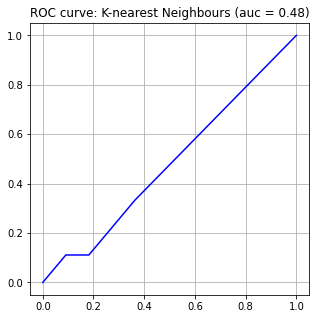

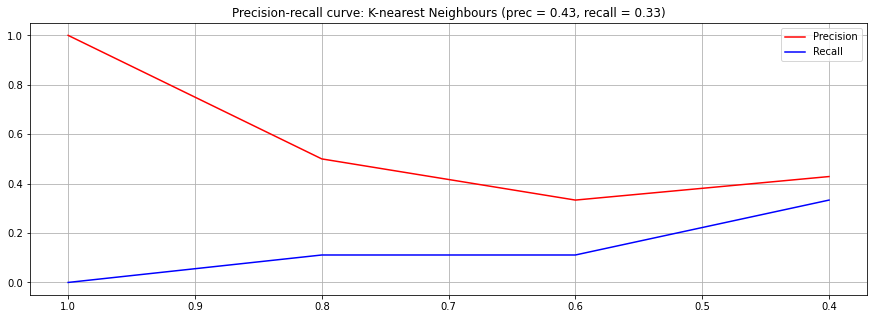

In [80]:
# K-neighbours
model_name = 'K-nearest Neighbours'
model = KNeighborsClassifier(5).fit(X_train, y_train)
pred = model.predict_proba(X_val)[:, 1]
log_mlflow(run_params, model, model_name, y_val, pred)

[05/Dec/2021 00:40:31] INFO - AUC: 0.323 | Recall: 0.222 | Precision: 0.250 | F1: 0.235
[05/Dec/2021 00:40:31] INFO - ROC curve saved to: ../artifact_dir/plots/roc_curve_Gradient Boosting Machine (auc = 0.32).png
[05/Dec/2021 00:40:31] INFO - Precision-recall curve saved to: ../artifact_dir/plots/precision_recall_Gradient Boosting Machine (prec = 0.25, recall = 0.22).png
[05/Dec/2021 00:40:31] INFO - Model saved to: ../artifact_dir/models/Gradient Boosting Machine.pickle


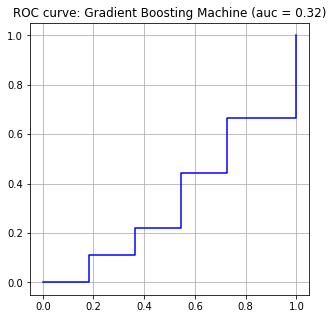

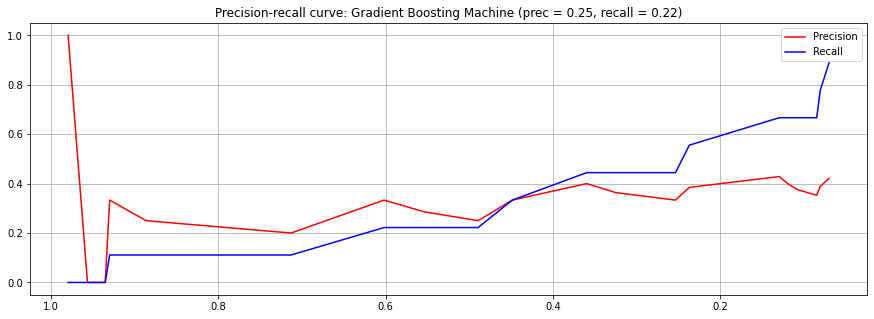

In [81]:
# Gradient Boosting
model_name = 'Gradient Boosting Machine'
model = GradientBoostingClassifier().fit(X_train, y_train)
pred = model.predict_proba(X_val)[:, 1]
log_mlflow(run_params, model, model_name, y_val, pred)

[05/Dec/2021 00:40:32] INFO - AUC: 0.444 | Recall: 0.444 | Precision: 0.444 | F1: 0.444
[05/Dec/2021 00:40:32] INFO - ROC curve saved to: ../artifact_dir/plots/roc_curve_Extra Trees (auc = 0.44).png
[05/Dec/2021 00:40:32] INFO - Precision-recall curve saved to: ../artifact_dir/plots/precision_recall_Extra Trees (prec = 0.44, recall = 0.44).png
[05/Dec/2021 00:40:32] INFO - Model saved to: ../artifact_dir/models/Extra Trees.pickle


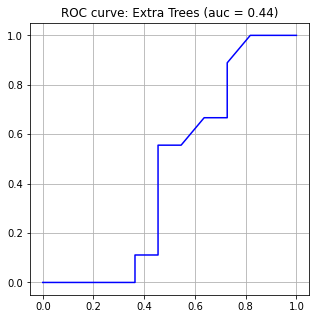

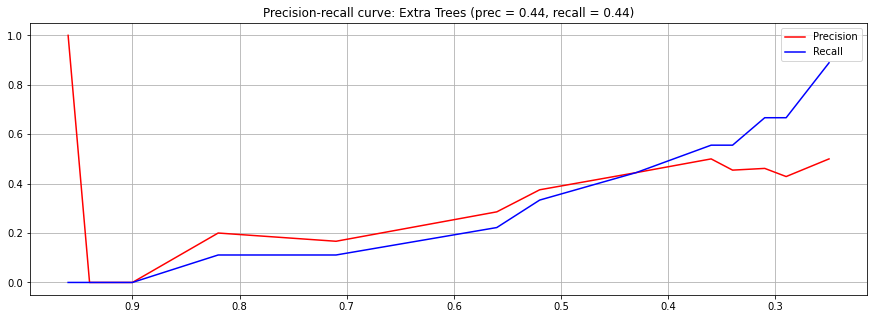

In [82]:
# Bagged trees
model_name = 'Extra Trees'
model = ExtraTreesClassifier().fit(X_train, y_train)
pred = model.predict_proba(X_val)[:, 1]
log_mlflow(run_params, model, model_name, y_val, pred)

### Test loading model

In [83]:
model_name = 'Support Vector Classifier'
check_model = load('{}/models/{}.pickle'.format(ARTIFACT_DIR, model_name))

In [84]:
check_model

SVC(C=1, gamma=2, probability=True)

In [85]:
pred = check_model.predict_proba(X_val)[:, 1]

In [86]:
evaluate_binary(y_val, pred)

[05/Dec/2021 00:40:33] INFO - AUC: 0.707 | Recall: 1.000 | Precision: 0.450 | F1: 0.621


(0.7070707070707071, 1.0, 0.45, 0.6206896551724138)